# Introduction
This notebook is used as a demonstration/introduction to propensity score matching. It uses the Kaggle Titanic dataset (https://www.kaggle.com/c/titanic). The main goal is to estimate the effect of a treatment (i.e. the passenger has a cabin) on the final survival of passengers. 

The dataset helps illustrate how we could potentially assess the impact of a treatment in cases where we cannot perform a RCT (randomised controlled testing) on the subjects.

1. <a href='#Key-points'>Key points</a>
2. <a href='#Approach'>Approach</a>
3. <a href='#Data-Preparation'>Data Preparation</a>
4. <a href='#Matching-Implementation'>Matching implementation</a>
5. <a href='#Matching-Review'>Matching Review</a>
6. <a href='#Average-Treatement-effect'>Average Treatement Effect</a>
7. <a href='#References'>References</a>

# Key points
In order to proceed to PSM (propensity score matching), the following key points are considered:
- Dimensions:
    - X are the underlying characteristics/features available.
    - T is the treatment; can be either 1 or 0. In this notebook the presence of a cabin is considered as T=1 (i.e. the passenger got treated).
    - Y is the outcome variable i.e. survived or not.
- Propensity score is the estimated probability that a subject/passenger is treated given certain observable characteristics X. In probability notation this is P(T=1|X). Propensity Score is used to "minimize/compress" the dimensions. This solves the curse of dimensionality but on the other hand there is loss of information.
- The propensity score is calculated (usually) by logistic regression having T (treatment) as the outcome variable.
- There is a cost in not doing a proper RCT (randomised controlled testing). Treatment groups might not fully overlap (common support) or not all of characteristics X (i.e. age, fare etc.) might be equally distributed within the treatment groups.

Key assumptions & conditions:
- Identification condition: observations with similar characteristics X are present in both treatment and control groups. 
- Conditional independence assumption: There are no unobserved differences correlated to potential outcomes once we have controlled for certain observable characteristics
- Unconfoundedness assumption: Selection on treatment (or not) should be solely based on observable characteristics (i.e. X). Assuming there is no selection bias from unobserved characteristics. It is not possible to prove the validity of this unconfoundedness assumption.

Misc:
- There are studies suggesting that Propensity Score is not the optimum method to perform matching. #TODO: Add reference

# Approach
1. Estimate the propensity score. This is the propability (logistic regression) that an observation is treated or not. Then convert it to its logit value.
2. Perform matching. For each treated sample, identify an untreated sample with similar logit propensity score. The matching is 1-to-1 with replacement. In cases where we do not have enough untreated elements, then the same one can be re-used. The matching takes place using the treated elements as source.
3. Once matching is performed, we review the balance of the X variables to assess their balance.
4. Estimate the impact of treatment.

# Data Preparation

In [1]:
from sklearn.linear_model import LogisticRegression as lr

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics

In [2]:
# Enabled to remove warnings for demo purposes.
import warnings
warnings.filterwarnings('ignore')

In [3]:
from functions import *
import math
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(16,10)})


Bad key "text.kerning_factor" on line 4 in
/Users/konos/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
df = pd.read_csv('train.csv')
# Elements are dropped for simplicity.
df = df[~df.Age.isna()]
df = df[~df.Embarked.isna()]
df = df.reset_index()
y = df[['Survived']]
df = df.drop(columns = ['Survived'])

Create an artificial treatment effect. It is based on the condition that a passenger has a cabin (1) or not (0). The 'hasCabin' function is imported from the functions.py file.

In [5]:
df['treatment'] = df.Cabin.apply(hasCabin)

There is high correlation between treatment (i.e. hasCabin) and Class.
This is desirable in this case as it plays the role of the systematic factor affecting the treatment.
In a different context this could be a landing page on site that only specific visitors see.

In [6]:
pd.pivot_table(df[['treatment','Pclass','PassengerId']], \
               values = 'PassengerId', index = 'treatment', columns = 'Pclass',\
               aggfunc= np.count_nonzero)

Pclass,1,2,3
treatment,,,
0,26,158,345
1,158,15,10


Keeping only specific variables.
We should account for all variables that affect the treatment variable (i.e. hasCabin).

In [7]:
df_data = df[['treatment','Sex','Age','SibSp','Parch','Embarked', 'Pclass', 'Fare']]

In [8]:
T = df_data.treatment
X = df_data.loc[:,df_data.columns !='treatment']

In [9]:
X_encoded = pd.get_dummies(X, columns = ['Sex','Embarked', 'Pclass'], \
                           prefix = {'Sex':'sex', 'Embarked' : 'embarked', 'Pclass' : 'class'}, drop_first=False)

In [10]:
# Design pipeline to build the treatment estimator
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_classifier', lr())
])

pipe.fit(X_encoded, T)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic_classifier', LogisticRegression())])

In [11]:
predictions = pipe.predict_proba(X_encoded)
predictions_binary = pipe.predict(X_encoded)

In [12]:
print('Accuracy: {:.4f}\n'.format(metrics.accuracy_score(T, predictions_binary)))
print('Confusion matrix:\n{}\n'.format(metrics.confusion_matrix(T, predictions_binary)))
print('F1 score is: {:.4f}'.format(metrics.f1_score(T, predictions_binary)))

Accuracy: 0.9284

Confusion matrix:
[[503  26]
 [ 25 158]]

F1 score is: 0.8610


Convert propability to logit (based on the suggestion at https://youtu.be/gaUgW7NWai8?t=981)

In [13]:
predictions_logit = np.array([logit(xi) for xi in predictions[:,1]])

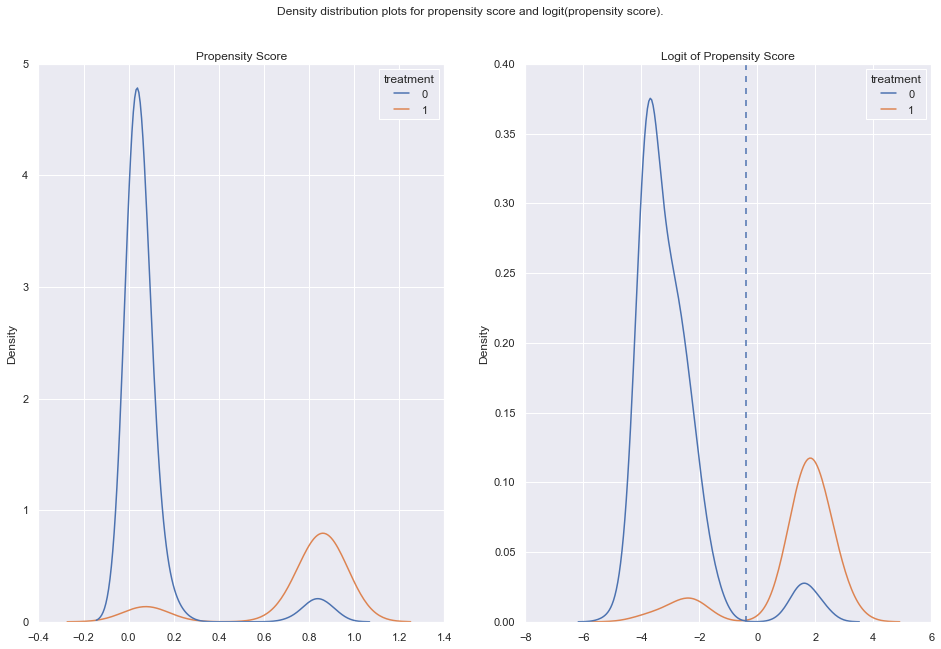

In [14]:
# Density distribution of propensity score (logic) broken down by treatment status
fig, ax = plt.subplots(1,2)
fig.suptitle('Density distribution plots for propensity score and logit(propensity score).')
sns.kdeplot(x = predictions[:,1], hue = T , ax = ax[0])
ax[0].set_title('Propensity Score')
sns.kdeplot(x = predictions_logit, hue = T , ax = ax[1])
ax[1].axvline(-0.4, ls='--')
ax[1].set_title('Logit of Propensity Score')
plt.show()

The graph on the right (logit_propensity_score) demonstrates the density for each treatment status. There is overlap accross the range of values (-6,5). However on the left of "-0.4" there are a lot more 0's than 1's. On the right side of "-0.4", the opposite is true (a lot more 1's than 0's). 

This will affect later how we will perform the matching so we can have balanced groups. In practise, this means that for values X > -0.4, there are less untreated samples than treated. This will lead to untreated samples being used for more than one treated.

In [15]:
# Currently this does not affect the results as all observations fall within this range.
common_support = (predictions_logit > -10) & (predictions_logit < 10)

In [16]:
df_data.loc[:,'propensity_score'] = predictions[:,1]
df_data.loc[:,'propensity_score_logit'] = predictions_logit
df_data.loc[:,'outcome'] = y.Survived

X_encoded.loc[:,'propensity_score'] = predictions[:,1]
X_encoded.loc[:,'propensity_score_logit'] = predictions_logit
X_encoded.loc[:,'outcome'] = y.Survived
X_encoded.loc[:,'treatment'] = df_data.treatment

## Matching Implementation
Use Nearerst Neighbors to identify matching candidates. Then perform 1-to-1 matching by isolating/identifying groups of (T=1,T=0).
- Caliper: 25% of standart deviation of logit(propensity score)

In [17]:
caliper = np.std(df_data.propensity_score) * 0.25

print('\nCaliper (radius) is: {:.4f}\n'.format(caliper))

df_data = X_encoded

knn = NearestNeighbors(n_neighbors=10 , p = 2, radius=caliper)
knn.fit(df_data[['propensity_score_logit']].to_numpy())


Caliper (radius) is: 0.0889



NearestNeighbors(n_neighbors=10, radius=0.08890268148266278)

For each data point (based on the logit propensity score) obtain (at most) 10 nearest matches. This is regardless of their treatment status.

In [18]:
# Common support distances and indexes
distances , indexes = knn.kneighbors(
    df_data[['propensity_score_logit']].to_numpy(), \
    n_neighbors=10)

In [19]:
print('For item 0, the 4 closest distances are (first item is self):')
for ds in distances[0,0:4]:
    print('Element distance: {:4f}'.format(ds))
print('...')

For item 0, the 4 closest distances are (first item is self):
Element distance: 0.000000
Element distance: 0.000021
Element distance: 0.001106
Element distance: 0.004490
...


In [20]:
print('For item 0, the 4 closest indexes are (first item is self):')
for idx in indexes[0,0:4]:
    print('Element index: {}'.format(idx))
print('...')

For item 0, the 4 closest indexes are (first item is self):
Element index: 0
Element index: 607
Element index: 539
Element index: 301
...


In [21]:
def perfom_matching_v2(row, indexes, df_data):
    current_index = int(row['index']) # Obtain value from index-named column, not the actual DF index.
    prop_score_logit = row['propensity_score_logit']
    for idx in indexes[current_index,:]:
        if (current_index != idx) and (row.treatment == 1) and (df_data.loc[idx].treatment == 0):
            return int(idx)
         
df_data['matched_element'] = df_data.reset_index().apply(perfom_matching_v2, axis = 1, args = (indexes, df_data))

In [22]:
treated_with_match = ~df_data.matched_element.isna()

In [23]:
treated_matched_data = df_data[treated_with_match][df_data.columns]
treated_matched_data.head(3)

,Age,SibSp,Parch,Fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,class_1,class_2,class_3,propensity_score,propensity_score_logit,outcome,treatment,matched_element
1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0,0.866755,1.872566,1,1,62.0
3,35.0,1,0,53.1000,1,0,0,0,1,1,0,0,0.895107,2.144005,1,1,306.0
5,54.0,0,0,51.8625,0,1,0,0,1,1,0,0,0.805110,1.418544,0,1,372.0


In [24]:
def obtain_match_details(row, all_data, attribute):
    return all_data.loc[row.matched_element][attribute]

untreated_matched_data = pd.DataFrame(data = treated_matched_data.matched_element)

attributes = ['Age', 'SibSp', 'Parch', 'Fare', 'sex_female', 'sex_male', 'embarked_C',
       'embarked_Q', 'embarked_S', 'class_1', 'class_2', 'class_3',
       'propensity_score', 'propensity_score_logit', 'outcome', 'treatment']
for attr in attributes:
    untreated_matched_data[attr] = untreated_matched_data.apply(obtain_match_details, axis = 1, all_data = df_data, attribute = attr)
    
untreated_matched_data = untreated_matched_data.set_index('matched_element')
untreated_matched_data.head(3)

,Age,SibSp,Parch,Fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,class_1,class_2,class_3,propensity_score,propensity_score_logit,outcome,treatment
matched_element,,,,,,,,,,,,,,,,
62.0,28.0,0.0,0.0,47.10,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.866278,1.868444,0.0,0.0
306.0,35.0,1.0,0.0,52.00,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.895251,2.145533,1.0,0.0
372.0,56.0,0.0,0.0,26.55,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.805278,1.419613,0.0,0.0


In [25]:
untreated_matched_data.shape

(143, 16)

In [26]:
treated_matched_data.shape

(143, 17)

In [27]:
all_mached_data = pd.concat([treated_matched_data, untreated_matched_data])

In [28]:
all_mached_data.treatment.value_counts()

0.0    143
1.0    143
Name: treatment, dtype: int64

# Matching Review

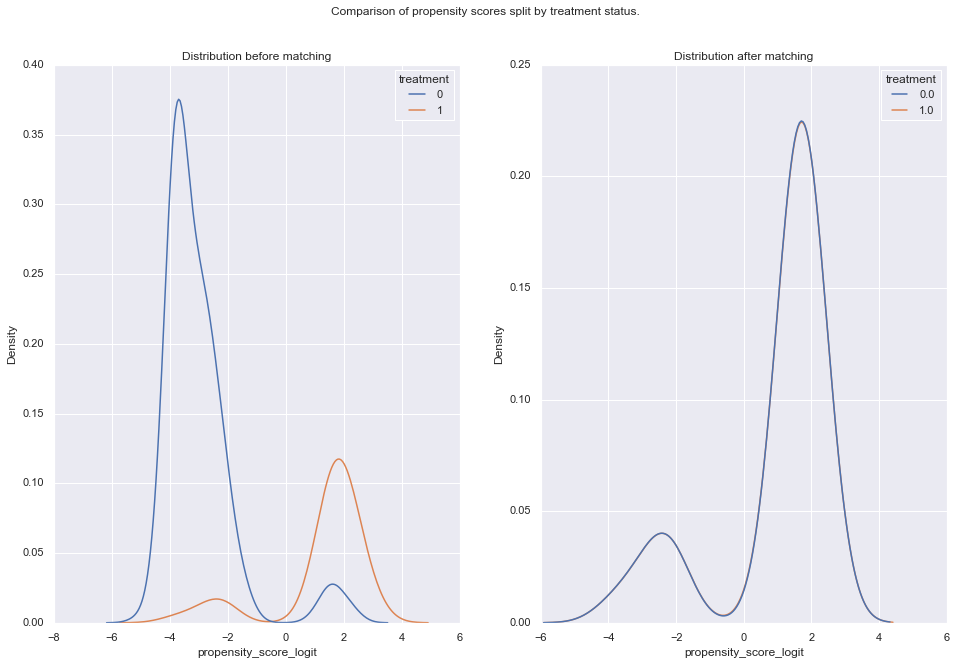

In [29]:
fig, ax = plt.subplots(1,2)
fig.suptitle('Comparison of propensity scores split by treatment status.')
sns.kdeplot(data = df_data, x = 'propensity_score_logit', hue = 'treatment', ax = ax[0]).set(title='Distribution before matching')
sns.kdeplot(data = all_mached_data, x = 'propensity_score_logit', hue = 'treatment',  ax = ax[1]).set(title='Distribution after matching')
plt.show()

In [30]:
points_df = pd.merge(treated_matched_data[['Age','Fare','matched_element']], df_data[['Age','Fare']], how = 'right',  left_on = 'matched_element', right_index=True)

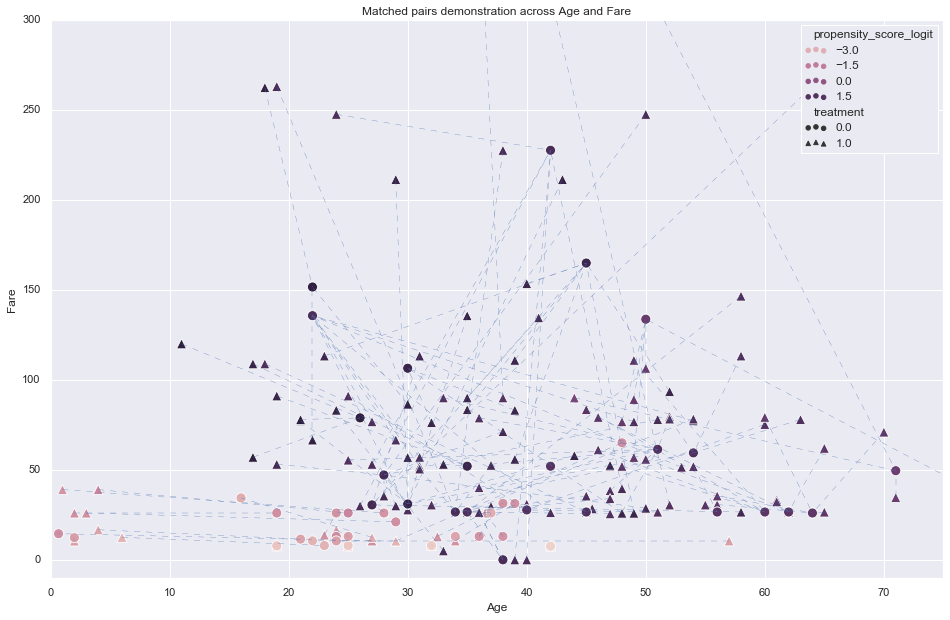

In [31]:
markers = {0: 'o', 1: '^'}
sns.scatterplot(data = all_mached_data, x = 'Age', y = 'Fare', style = 'treatment', s = 100, markers = markers, hue = 'propensity_score_logit').\
    set(xlim=(0, 75), ylim=(-10, 300))
plt.title('Matched pairs demonstration across Age and Fare')

def add_lines(row):
    x1 = row.Age_x
    y1 = row.Fare_x
    x2 = row.Age_y
    y2 = row.Fare_y
    plt.plot([x1, x2], [y1, y2], linewidth=0.3, color = 'b', linestyle='dashed' )

t = points_df.apply(add_lines, axis = 1)

The above chart demonstrates the result of the matching. Let's unpack the information it contains.
- Triangle depict treated samples and Circles untreated samples.
- A triangle is always matched with one (or more) a circles.
- Matched elements have similar propensity score (i.e. same color of shape).
- Matched elements might have big difference in some of their dimensions (i.e. Age gap) but their propensity score is always very close. This also demonstrates the fact that propensity scores lead to loss of information (due to the compression of multiple dimensions to a single number). 

In [32]:
data = []
cols = ['Age','SibSp','Parch','Fare','sex_female','sex_male','embarked_C','embarked_Q','embarked_S','class_1','class_2','class_3']
# cols = ['Age','SibSp','Parch','Fare','sex_female','sex_male','embarked_C','embarked_Q','embarked_S']
for cl in cols:
    data.append([cl,'before', cohenD(df_data,cl)])
    data.append([cl,'after', cohenD(all_mached_data,cl)])

In [33]:
res = pd.DataFrame(data, columns=['variable','matching','effect_size'])

[Text(0.5, 1.0, 'Mean differences between treatment groups before and after matching.')]

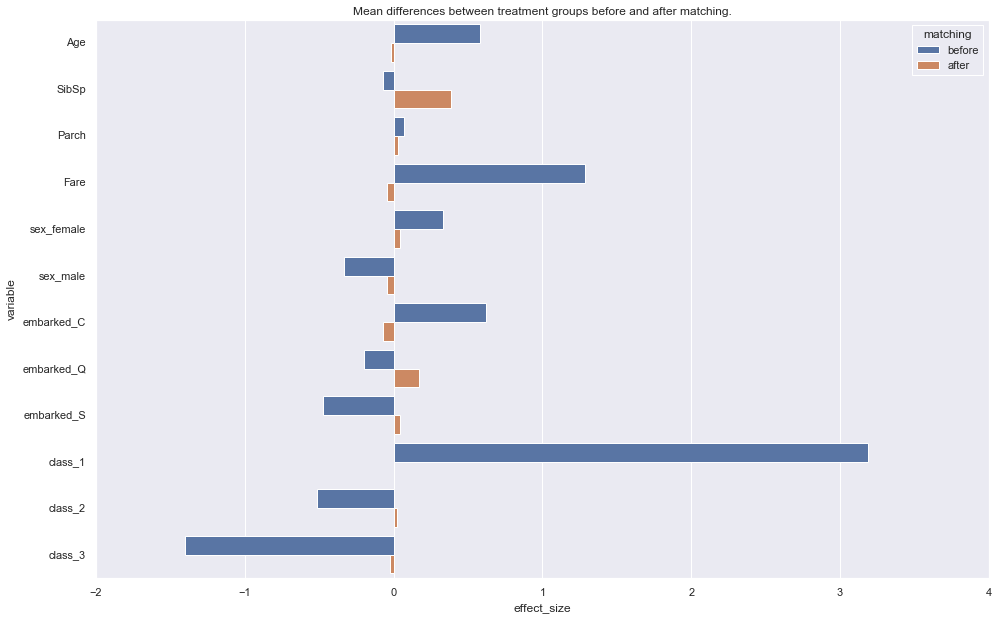

In [34]:
sns.barplot(data = res, y = 'variable', x = 'effect_size', hue = 'matching', orient='h').\
    set(title='Mean differences between treatment groups before and after matching.')

In [35]:
cols.append('treatment')

Dimensions overview before matching


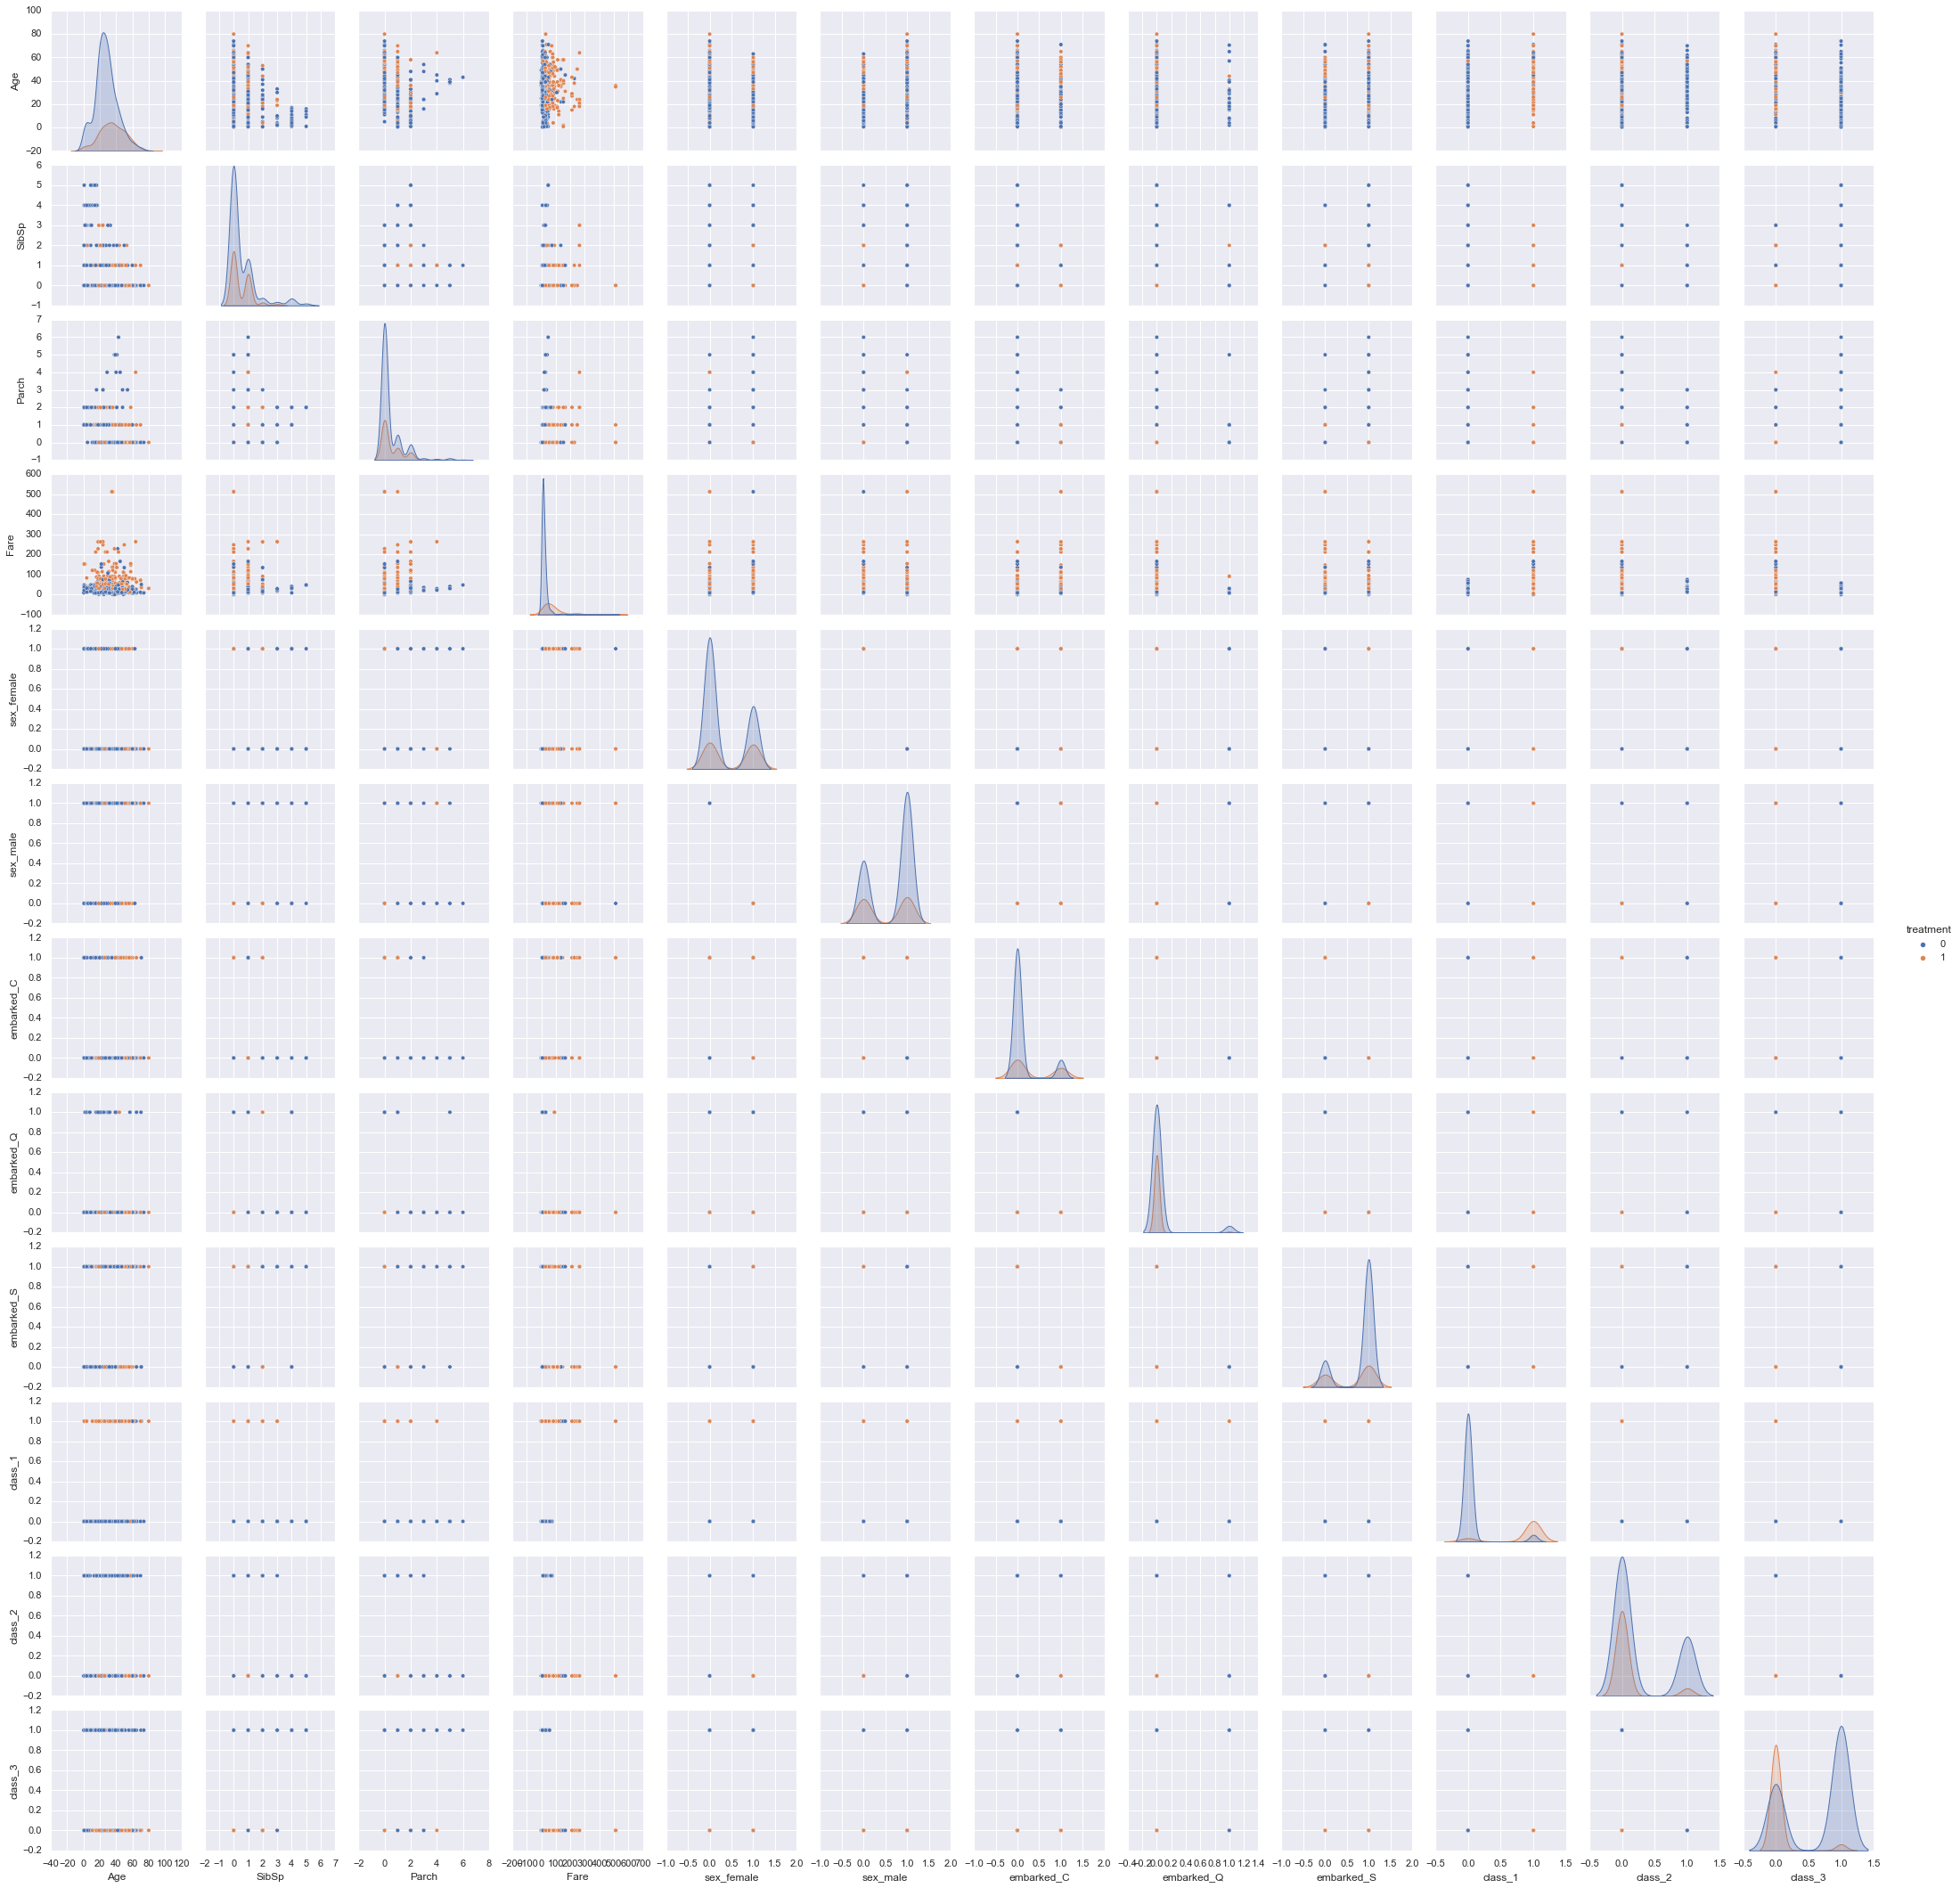

In [36]:
sns.pairplot(data = df_data[cols], hue = 'treatment')
print('Dimensions overview before matching')

Dimensions overview after matching


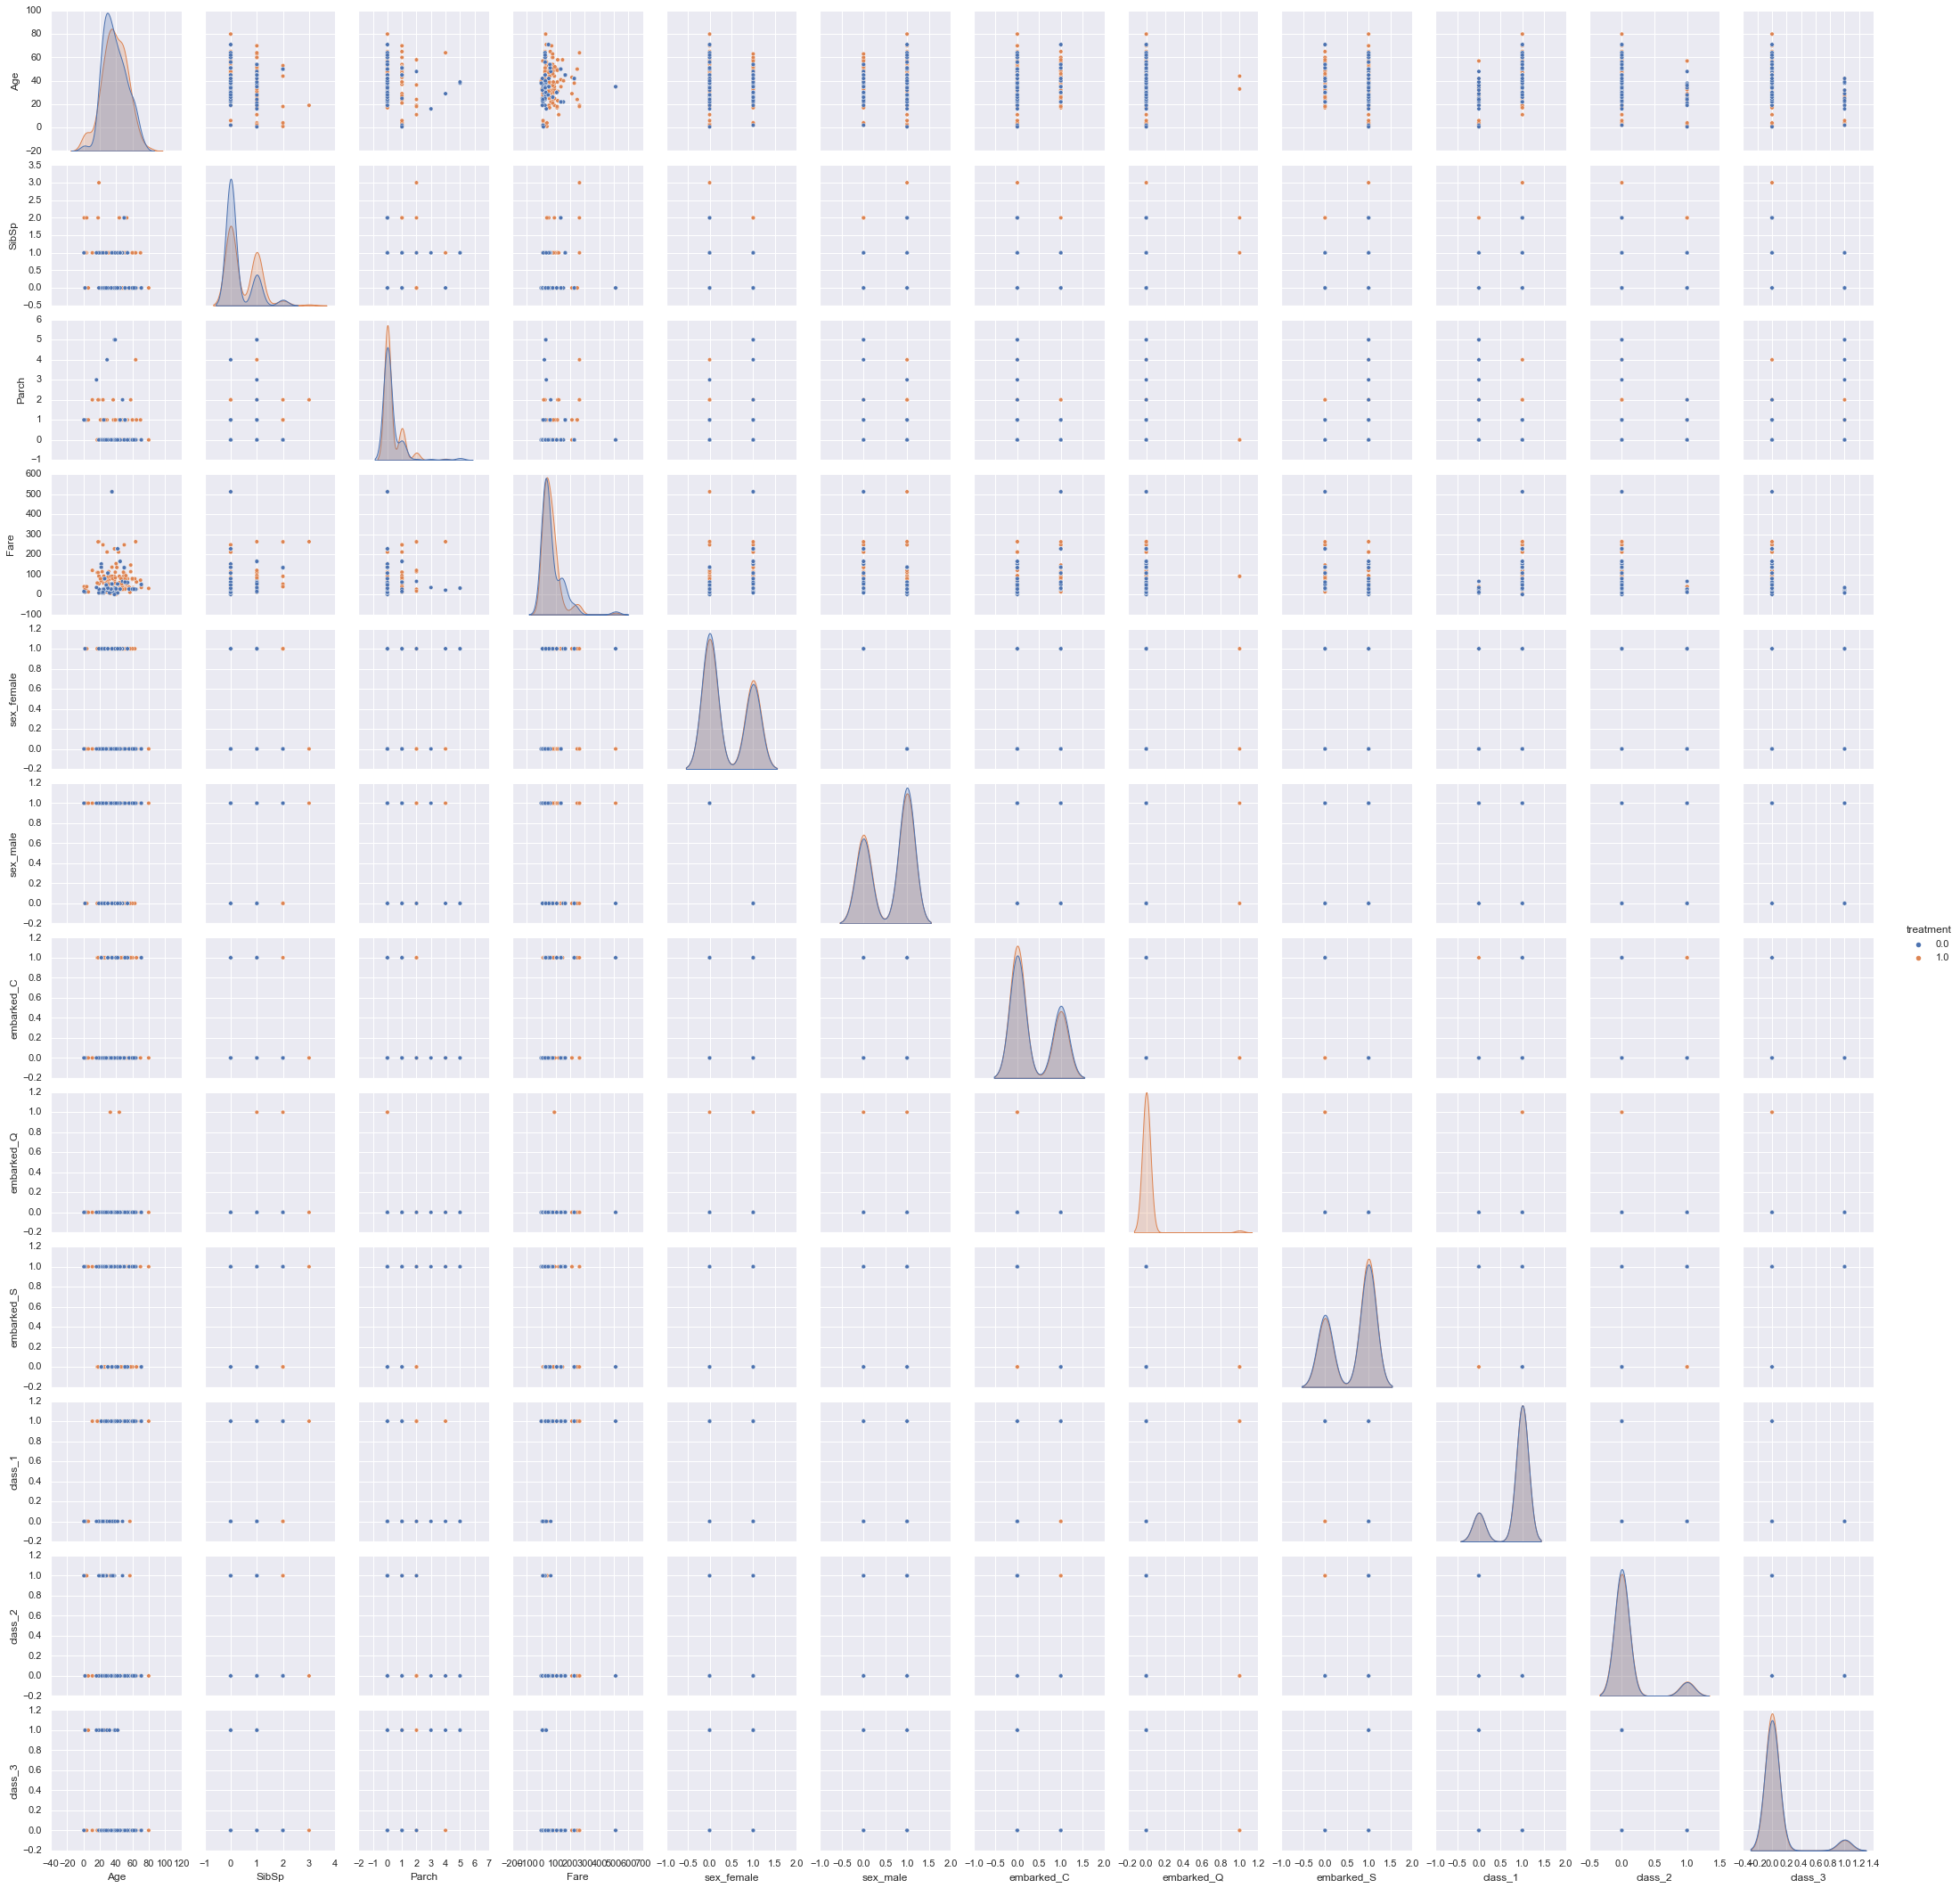

In [37]:
sns.pairplot(data = all_mached_data[cols], hue = 'treatment')
print('Dimensions overview after matching')

# Average Treatement effect

In [38]:
all_mached_data[['outcome','treatment']].groupby(by = ['treatment']).aggregate([np.mean, np.var])

outcome          
               mean       var
treatment                    
0.0        0.510490  0.251650
1.0        0.622378  0.236679

In [39]:
treated_outcome = treated_matched_data.outcome
untreated_outcome = untreated_matched_data.outcome
stats_results = stats.ttest_ind(treated_outcome, untreated_outcome)

In [40]:
print('p-value: {:.4f}'.format(stats_results.pvalue))

p-value: 0.0565


# References
- The central role of the propensity score in observational studies for causal effects. https://academic.oup.com/biomet/article/70/1/41/240879?login=true
- Average Causal Effects From Nonrandomized Studies: A Practical Guide and Simulated Example https://www.researchgate.net/profile/Joseph_Kang4/publication/23652902_Average_Causal_Effects_From_Nonrandomized_Studies_A_Practical_Guide_and_Simulated_Example/links/565effb308ae1ef929843ae4/Average-Causal-Effects-From-Nonrandomized-Studies-A-Practical-Guide-and-Simulated-Example.pdf
- Logit function definition: https://en.wikipedia.org/wiki/Logit
- Matching Methods: https://www.youtube.com/watch?v=CEikQRj5n_A
- Propensity Score Matching: https://www.youtube.com/watch?v=8KE0qj5Ef0c
- Propensity Score Matching - HelloFresh: https://www.youtube.com/watch?v=gaUgW7NWai8
- Introduction to Propensity Score Matching: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/
- https://florianwilhelm.info/2017/04/causal_inference_propensity_score/
- Cohen's d: https://en.wikipedia.org/wiki/Effect_size#Cohen's_d
- Python package pymatch: https://github.com/benmiroglio/pymatch